## 01 - [SANDBOX] Exploratory Data Analysis (EDA)
Challenge Data Analyst - NeuralWorks  
Postulante: Ignacio Tapia  
Diciembre 2022

In [1]:
import os
os.chdir('../')

import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils import database as db

# 
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
sns.set_theme()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df_match = db.read_from_sqlite(sql_file='queries/select/matches.sql', path_db='data/database.sqlite')
df_player = db.read_from_sqlite(sql_file='queries/select/players-attributes-season.sql', path_db='data/database.sqlite')
df_player_overall_rating = db.read_from_sqlite(sql_file='queries/select/historical_mean_overall_rating.sql', path_db='data/database.sqlite')

df_player = df_player.loc[:,~df_player.columns.duplicated()]

### Feature Engineer

In [3]:
# Resultado Final (Home-Draw-Away) (H-D-A)
def final_result(home_goal, away_goal):
    
    if home_goal > away_goal:
        return 'H'
    elif home_goal < away_goal:
        return 'A'
    else:
        return 'D'
    
df_match['final_result'] = df_match.apply(lambda x: final_result(x['home_team_goal'], x['away_team_goal']), axis=1)


df_match['home_win'] = df_match['final_result'].apply(lambda x: 1 if x=='H' else 0)
df_match['home_loss'] = df_match['final_result'].apply(lambda x: 1 if x=='A' else 0)
df_match['away_win'] = df_match['final_result'].apply(lambda x: 1 if x=='A' else 0)
df_match['draw'] = df_match['final_result'].apply(lambda x: 1 if x=='D' else 0)

In [4]:
df_match['home_points'] = df_match['final_result'].map({'H':3, 'D':1, 'A':0})
df_match['away_points'] = df_match['final_result'].map({'H':0, 'D':1, 'A':3})

In [5]:
df_match[['home_team_goal', 'away_team_goal', 'final_result', 'home_points']].head()

,home_team_goal,away_team_goal,final_result,home_points
0,1,1,D,1
1,0,0,D,1
2,0,3,A,0
3,5,0,H,3
4,1,3,A,0


### Frecuencia de los Datos

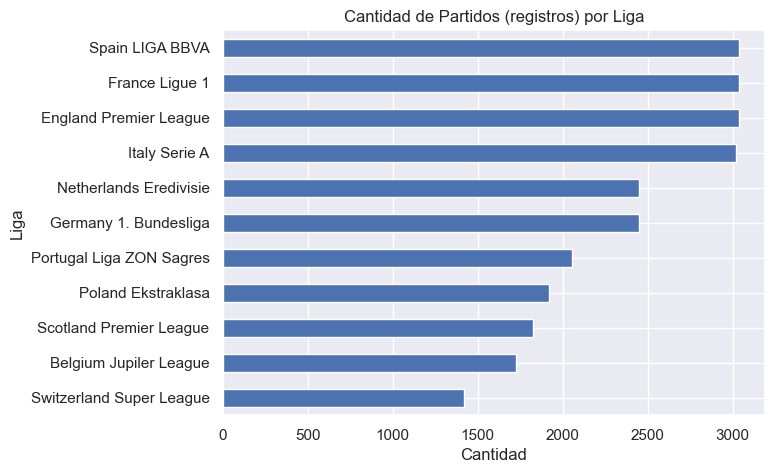

In [6]:
plt.figure(figsize=(7,5))
df_match.groupby('league_name')['id'].count().sort_values(ascending=True).plot(kind='barh')
plt.title('Cantidad de Partidos (registros) por Liga')
plt.xlabel('Cantidad')
plt.ylabel('Liga')
plt.show()

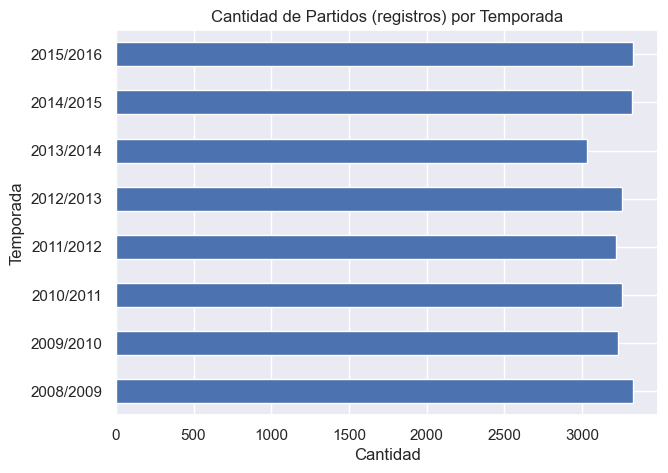

In [7]:
plt.figure(figsize=(7,5))
df_match.groupby(['season'])['id'].count().plot(kind='barh')
plt.title('Cantidad de Partidos (registros) por Temporada')
plt.xlabel('Cantidad')
plt.ylabel('Temporada')
plt.show()

### Análisis de Sistemas Tácticos

In [8]:
df_match['home_player_X1'] = 5.0
df_match['home_player_Y1'] = 1.0
df_match['away_player_X1'] = 5.0
df_match['away_player_Y1'] = 1.0

In [9]:
def get_playing_system(y_pos):
    
    #Contar jugadores por línea
    line_count = y_pos.value_counts().sort_index(ascending=True)
    
    #Generar lista con sistema de juego
    ply_sys_list = [str(x) for x in line_count]
    
    if sum(line_count) == 11 and ply_sys_list[0] == '1':
        ply_sys_string = '-'.join(ply_sys_list)
        return ply_sys_string
    else:
        return None

In [10]:
df_match['home_playing_sys'] = df_match.iloc[:,33:44].apply(get_playing_system, axis=1)
df_match['away_playing_sys'] = df_match.iloc[:,44:55].apply(get_playing_system, axis=1)

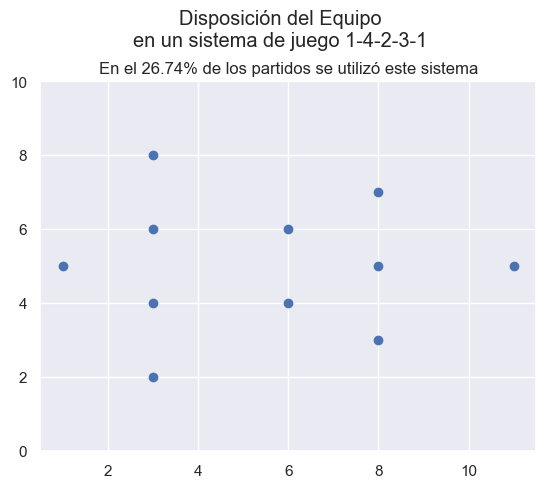

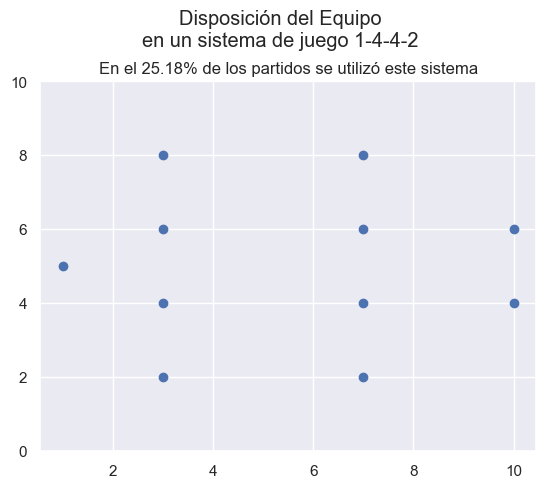

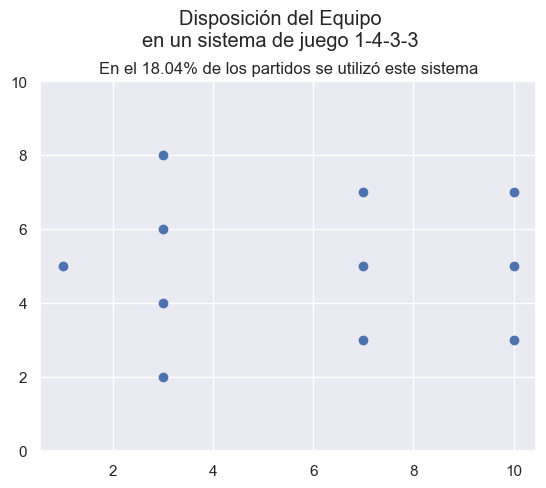

In [11]:
ply_sys_frequency = df_match['away_playing_sys'].value_counts(1)[:3]

for ply_sys in ply_sys_frequency.index:
        
    ply_sys_index = df_match[df_match['away_playing_sys'] == ply_sys].index[0]
    
    pos_x = df_match.iloc[ply_sys_index,22:33]
    pos_y = df_match.iloc[ply_sys_index,44:55]
    
    plt.scatter(pos_y, pos_x)
    plt.suptitle(f'Disposición del Equipo\nen un sistema de juego {ply_sys}', y=1.03)
    plt.title(f'En el {round(ply_sys_frequency[ply_sys] * 100,2)}% de los partidos se utilizó este sistema')
    plt.ylim((0,10))
    plt.show()

In [12]:
top_5_home_ply_sys = df_match.groupby(['home_playing_sys'])[['id']].count().sort_values(by='id',ascending=False)[:5]
top_5_away_ply_sys = df_match.groupby(['away_playing_sys'])[['id']].count().sort_values(by='id',ascending=False)[:5]

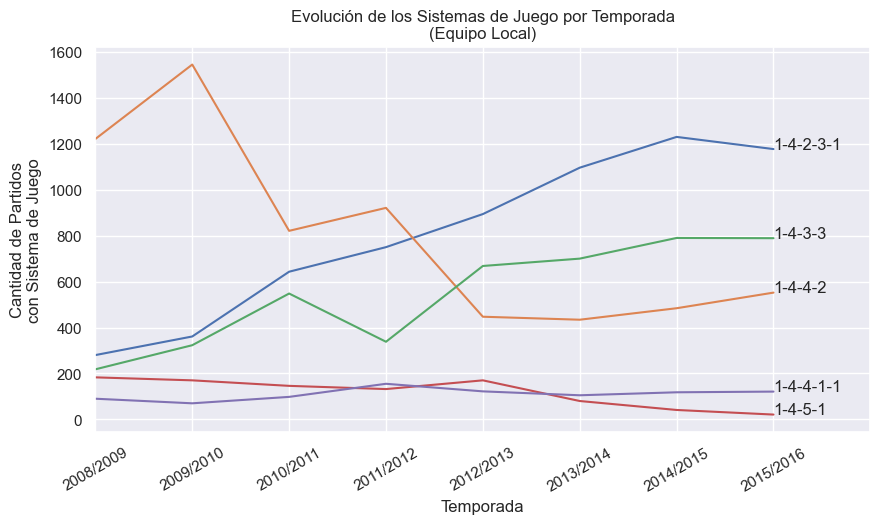

In [13]:
plt.figure(figsize=(10,5))
for ply_sys in top_5_home_ply_sys.index:

    df_temp = df_match[df_match['home_playing_sys'] == ply_sys]
    
    df_temp = df_temp.groupby('season').count()['id'].reset_index()
    plt.plot(df_temp['season'], df_temp['id'])
    plt.xlim(0,8)
    plt.xticks(rotation=30)
    
    x_annotate = len(df_temp['season'])
    y_annotate = list(df_temp['id'])[-1]
    
    plt.annotate(text=ply_sys, xy=(x_annotate-1,y_annotate))

plt.title('Evolución de los Sistemas de Juego por Temporada\n(Equipo Local)')
plt.ylabel('Cantidad de Partidos\ncon Sistema de Juego')
plt.xlabel('Temporada')
plt.show()

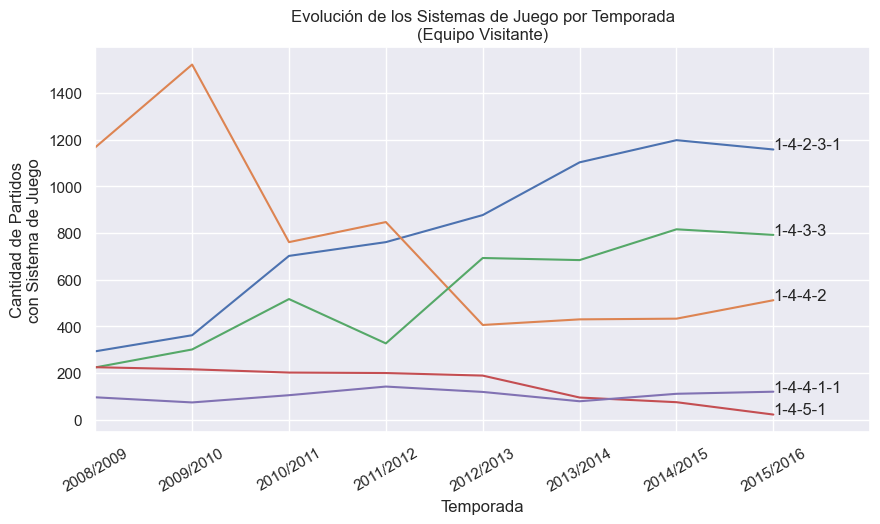

In [14]:
plt.figure(figsize=(10,5))
for ply_sys in top_5_home_ply_sys.index:

    df_temp = df_match[df_match['away_playing_sys'] == ply_sys]
    
    df_temp = df_temp.groupby('season').count()['id'].reset_index()
    plt.plot(df_temp['season'], df_temp['id'])
    plt.xlim(0,8)
    plt.xticks(rotation=30)
    
    x_annotate = len(df_temp['season'])
    y_annotate = list(df_temp['id'])[-1]
    
    plt.annotate(text=ply_sys, xy=(x_annotate-1,y_annotate))

plt.title('Evolución de los Sistemas de Juego por Temporada\n(Equipo Visitante)')
plt.ylabel('Cantidad de Partidos\ncon Sistema de Juego')
plt.xlabel('Temporada')
plt.show()

In [15]:
df_points = df_match.groupby(['season','home_playing_sys'])['home_points']\
    .agg(['count','sum'])\
    .query('home_playing_sys in ["1-4-2-3-1", "1-4-4-2", "1-4-3-3"]')


df_points['potencial_points'] = df_points['count'] * 3
df_points['performance'] = df_points['sum'] / df_points['potencial_points']
df_points.reset_index(inplace=True)
df_points

,season,home_playing_sys,count,sum,potencial_points,performance
0,2008/2009,1-4-2-3-1,280,427,840,0.508333
1,2008/2009,1-4-3-3,218,386,654,0.590214
2,2008/2009,1-4-4-2,1221,2007,3663,0.547912
3,2009/2010,1-4-2-3-1,361,581,1083,0.536473
4,2009/2010,1-4-3-3,323,578,969,0.596491
5,2009/2010,1-4-4-2,1545,2663,4635,0.574542
6,2010/2011,1-4-2-3-1,643,1053,1929,0.545879
7,2010/2011,1-4-3-3,548,953,1644,0.579684
8,2010/2011,1-4-4-2,821,1337,2463,0.542834
9,2011/2012,1-4-2-3-1,750,1307,2250,0.580889


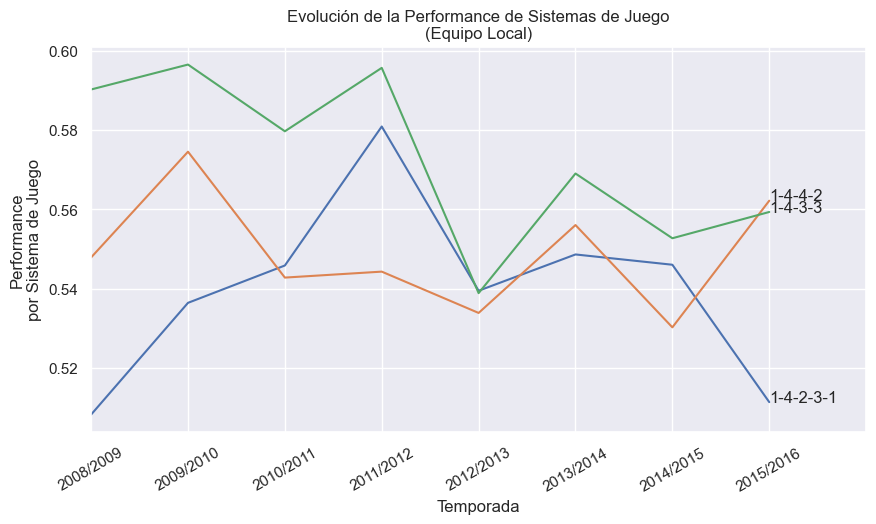

In [16]:
plt.figure(figsize=(10,5))
for ply_sys in ["1-4-2-3-1", "1-4-4-2", "1-4-3-3"]:

    df_temp = df_points[df_points['home_playing_sys'] == ply_sys]

    plt.plot(df_temp['season'], df_temp['performance'])
    plt.xlim(0,8)
    plt.xticks(rotation=30)
    
    x_annotate = len(df_temp['season'])
    y_annotate = list(df_temp['performance'])[-1]
    
    plt.annotate(text=ply_sys, xy=(x_annotate-1,y_annotate))

plt.title('Evolución de la Performance de Sistemas de Juego\n(Equipo Local)')
plt.ylabel('Performance\npor Sistema de Juego')
plt.xlabel('Temporada')
plt.show()

In [17]:
df_full_points = df_match.groupby(['home_playing_sys'])['home_points']\
    .agg(['count','sum'])\
    .query('home_playing_sys in ["1-4-2-3-1", "1-4-4-2", "1-4-3-3"]')

df_full_points = df_match[['home_playing_sys', 'home_points']].copy(deep=True)
df_full_points['potencial_points'] = 3
df_full_points['performance'] = df_full_points['home_points'] / df_full_points['potencial_points']
df_full_points.reset_index(inplace=True)
df_full_points.head()

,index,home_playing_sys,home_points,potencial_points,performance
0,0,None,1,3,0.333333
1,1,None,1,3,0.333333
2,2,None,0,3,0.000000
3,3,None,3,3,1.000000
4,4,None,0,3,0.000000


In [18]:
df_full_points.groupby('home_playing_sys')['performance']\
    .agg(['count','mean'])\
    .query('count > 1000')\
    .sort_values('mean',ascending=False)

,count,mean
home_playing_sys,,
1-4-3-3,4374,0.566225
1-4-4-2,6425,0.552633
1-4-2-3-1,6431,0.541129


In [19]:
mean_preformance_storage = {
    '1-4-3-3':[],
    '1-4-4-2':[],
    '1-4-2-3-1':[]
}

for i in tqdm(range(1000)):
    
    df_temp_1_4_3_3 = df_full_points[df_full_points['home_playing_sys'] == '1-4-3-3'].sample(400)
    df_temp_1_4_4_2 = df_full_points[df_full_points['home_playing_sys'] == '1-4-4-2'].sample(400)
    df_temp_1_4_2_3_1 = df_full_points[df_full_points['home_playing_sys'] == '1-4-2-3-1'].sample(400)
    
    performance_mean_1_4_3_3 = df_temp_1_4_3_3['performance'].mean()
    performance_mean_1_4_4_2 = df_temp_1_4_4_2['performance'].mean()
    performance_mean_1_4_2_3_1 = df_temp_1_4_2_3_1['performance'].mean()
    
    mean_preformance_storage['1-4-3-3'].append(performance_mean_1_4_3_3)
    mean_preformance_storage['1-4-4-2'].append(performance_mean_1_4_4_2)
    mean_preformance_storage['1-4-2-3-1'].append(performance_mean_1_4_2_3_1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.62it/s]


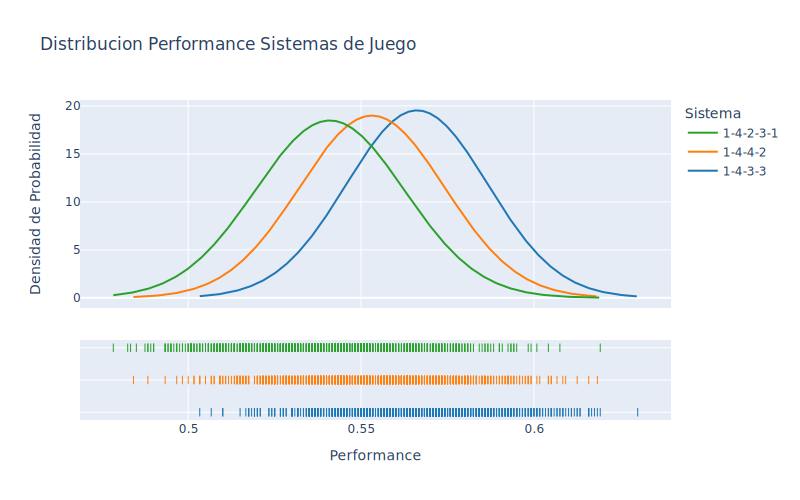

In [34]:
group_labels = list(mean_preformance_storage.keys())
hist_data = [x for x in mean_preformance_storage.values()]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_rug=True, curve_type='normal', show_hist=False)


fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title=f"Distribucion Performance Sistemas de Juego",
    xaxis_title="Performance",
    yaxis_title="Densidad de Probabilidad",
    legend_title="Sistema"
)


fig.show(renderer='svg')

In [22]:
from scipy.stats import ttest_ind

performance_1_4_3_3 = df_full_points[df_full_points['home_playing_sys'] == "1-4-3-3"]['performance'].reset_index(drop=True)
performance_1_4_4_2 = df_full_points[df_full_points['home_playing_sys'] == "1-4-4-2"]['performance'].reset_index(drop=True)
performance_1_4_2_3_1 = df_full_points[df_full_points['home_playing_sys'] == "1-4-2-3-1"]['performance'].reset_index(drop=True)

t_01, pvalue_01 = ttest_ind(a=performance_1_4_3_3, b=performance_1_4_4_2,alternative='greater')
t_02, pvalue_02 =  ttest_ind(a=performance_1_4_3_3, b=performance_1_4_2_3_1, alternative='greater')

print(f'H01: Performance_1_4_3_3 <= performance_1_4_4_2; (t-stat: {t_01:.3f}, p-val: {pvalue_01:.3f}) -> RH01')
print(f'H02: Performance_1_4_3_3 <= performance_1-4-2-3-1; (t-stat: {t_02:.3f}, p-val: {pvalue_02:.3f}) -> RH02')

H01: Performance_1_4_3_3 <= performance_1_4_4_2; (t-stat: 1.582, p-val: 0.057) -> RH01
H02: Performance_1_4_3_3 <= performance_1-4-2-3-1; (t-stat: 2.924, p-val: 0.002) -> RH02


### Análisis de Jugadores

In [23]:
storage = {
    
    'player_api_id':[],
    'position':[],
    'playing_sys':[]
    
}

df_match_clean = df_match[~df_match['home_playing_sys'].isnull()].reset_index(drop=True)

for index, data in df_match_clean.iterrows():
    
    for i in range(1,12):
        
        if data[f'home_player_{i}'] > 0 :

            player = int(data[f'home_player_{i}'])
        
            position_X = int(data[f'home_player_X{i}'])
            position_Y = int(data[f'home_player_Y{i}'])
            position = (position_X,position_Y)

            playing_sys = data['home_playing_sys']
            
            storage['player_api_id'].append(player)
            storage['position'].append(position)
            storage['playing_sys'].append(playing_sys)
        
        else:
            continue

In [24]:
df_metric_players = pd.DataFrame(storage)
df_metric_players['count'] = 1
df_metric_players.head()

,player_api_id,position,playing_sys,count
0,39890,"(5, 1)",1-4-4-2,1
1,38788,"(4, 3)",1-4-4-2,1
2,38312,"(6, 3)",1-4-4-2,1
3,26235,"(8, 3)",1-4-4-2,1
4,26916,"(8, 7)",1-4-4-2,1


In [25]:
df_metric_players_agg = df_metric_players.groupby(['player_api_id','position', 'playing_sys'])[['count']]\
                        .count()\
                        .sort_values('count', ascending=False)\
                        .query('count >= 10')\
                        .reset_index()

df_metric_players_agg.head()

,player_api_id,position,playing_sys,count
0,33988,"(2, 3)",1-4-3-3,104
1,35502,"(8, 3)",1-4-4-2,96
2,32657,"(5, 1)",1-4-3-3,90
3,27358,"(5, 1)",1-4-2-3-1,85
4,154257,"(5, 7)",1-4-3-3,82


In [26]:
df_metric_players_agg = df_metric_players_agg.merge(df_player_overall_rating,
                                                    left_on='player_api_id',
                                                    right_on='player_api_id',
                                                    how='left')

In [27]:
df_metric_players_agg.head()

,player_api_id,position,playing_sys,count,player_fifa_api_id,player_name,historical_mean_overall_reating
0,33988,"(2, 3)",1-4-3-3,104,146530,Daniel Alves,85.850000
1,35502,"(8, 3)",1-4-4-2,96,28178,Steven Hammell,67.558333
2,32657,"(5, 1)",1-4-3-3,90,106573,Victor Valdes,83.933333
3,27358,"(5, 1)",1-4-2-3-1,85,2196,Roman Weidenfeller,82.633333
4,154257,"(5, 7)",1-4-3-3,82,189511,Sergio Busquets,81.020370


In [28]:
df_metric_players_agg.query('player_api_id == 30829')

,player_api_id,position,playing_sys,count,player_fifa_api_id,player_name,historical_mean_overall_reating
1295,30829,"(6, 10)",1-4-4-2,23,54050,Wayne Rooney,88.743333
1495,30829,"(5, 8)",1-4-2-3-1,21,54050,Wayne Rooney,88.743333
2652,30829,"(4, 10)",1-4-4-2,16,54050,Wayne Rooney,88.743333
3436,30829,"(5, 9)",1-4-4-1-1,14,54050,Wayne Rooney,88.743333
3674,30829,"(5, 11)",1-4-2-3-1,13,54050,Wayne Rooney,88.743333


In [29]:
df_metric_players_agg.groupby(['player_api_id','player_name','playing_sys','position'])\
    [['count','historical_mean_overall_reating']]\
    .max()\
    .query('(playing_sys == "1-4-3-3") & (count > 30)')\
    .sort_values('historical_mean_overall_reating', ascending=False).head(12)

count  \
player_api_id player_name        playing_sys position          
30981         Lionel Messi       1-4-3-3     (5, 10)      62   
                                             (3, 10)      52   
30893         Cristiano Ronaldo  1-4-3-3     (7, 10)      35   
35724         Zlatan Ibrahimovic 1-4-3-3     (5, 10)      47   
30955         Andres Iniesta     1-4-3-3     (7, 7)       70   
39854         Xavi Hernandez     1-4-3-3     (3, 7)       76   
30859         Petr Cech          1-4-3-3     (5, 1)       43   
30627         John Terry         1-4-3-3     (6, 3)       38   
33988         Daniel Alves       1-4-3-3     (2, 3)      104   
26166         Karim Benzema      1-4-3-3     (5, 10)      40   
19533         Neymar             1-4-3-3     (7, 10)      40   
37482         Gerard Pique       1-4-3-3     (4, 3)       66   

                                                       historical_mean_overall_reating  
player_api_id player_name        playing_sys position                                   
30981         Lionel Messi       1-4-3-3     (5, 10)                         92.683333  
                                             (3, 10)                         92.683333  
30893         Cristiano Ronaldo  1-4-3-3     (7, 10)                         91.866667  
35724         Zlatan Ibrahimovic 1-4-3-3     (5, 10)                         89.041667  
30955         Andres Iniesta     1-4-3-3     (7, 7)                          88.588095  
39854         Xavi Hernandez     1-4-3-3     (3, 7)                          87.700000  
30859         Petr Cech          1-4-3-3     (5, 1)                          86.750000  
30627         John Terry         1-4-3-3     (6, 3)                          86.303333  
33988         Daniel Alves       1-4-3-3     (2, 3)                          85.850000  
26166         Karim Benzema      1-4-3-3     (5, 10)                         85.825000  
19533         Neymar             1-4-3-3     (7, 10)                         85.372024  
37482         Gerard Pique       1-4-3-3     (4, 3)                          85.166667